In [1]:
# Import useful libraries
from PIL import Image, ImageChops, ImageEnhance
from torchvision import transforms
import os
import os.path as path
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
import torch
import time
from collections import namedtuple

In [2]:
!featurize dataset download f0d1919b-9429-4c18-a660-7291e30bfbeb

100%|██████████████████████████████████████| 2.56G/2.56G [00:10<00:00, 254MiB/s]
🍬  下载完成，正在解压...
🏁  数据集已经成功添加


In [3]:
print(torch.version.cuda)
print(torch.cuda.is_available())

11.3
True


In [4]:
# Convert an image to ela image
# Input type: <class 'PIL.Image.Image'>
# Output type: <class 'PIL.Image.Image'>
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [5]:
# Change image size to be fitted into AlexNet
image_size = (224, 224)

def prepare_image(image_path, image_size):
    convert_tensor = transforms.ToTensor()
    return convert_tensor(convert_to_ela_image(image_path, 85).resize(image_size))


In [6]:
# real images
X = [] # ELA converted images
Y = [] # label: 0 for fake, 1 for real

image_size = (224, 224) 
path = 'data/CopyAndMove/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path, image_size))
        Y.append(1)

print(len(X), len(Y))

5000 5000


In [7]:
# fake images

path = 'data/CopyAndMove/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path, image_size))
        Y.append(0)

print(len(X), len(Y))

10000 10000


In [8]:
# Shuffle the data
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

In [9]:
# train, test, validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))
print(len(X_val), len(Y_val))

7200 7200
2000 2000
800 800


In [10]:
# Create dataloader
BATCH_SIZE = 256

train_iterator = data.DataLoader([[X_train[i], Y_train[i]] for i in range(len(Y_train))],
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader([[X_test[i], Y_test[i]] for i in range(len(Y_test))],
                                 batch_size=BATCH_SIZE)

val_iterator = data.DataLoader([[X_val[i], Y_val[i]] for i in range(len(Y_val))],
                                batch_size=BATCH_SIZE)

In [48]:
# Defining the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [49]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [50]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [51]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [52]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [53]:
OUTPUT_DIM = 2

model = ResNet(resnet18_config, OUTPUT_DIM)

In [54]:
# Parameter initialization
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
      nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
      if m.bias is not None:
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)
    #     nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
    #     nn.init.constant_(m.bias.data, 0)

In [55]:
# using pretrained params
import torchvision.models as models
pretrained_model = models.resnet18(pretrained = True)

IN_FEATURES = pretrained_model.fc.in_features 

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [56]:
pretrained_model.fc = fc

In [57]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [58]:
model.apply(initialize_parameters)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kerne

In [59]:
START_LR = 1e-4

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

Using device: cuda

NVIDIA RTX A6000
Memory Usage:
Allocated: 0.2 GB
Cached:    8.5 GB


In [60]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [61]:
# Trains the model
# Input: torch.nn.Module, data.Dataloader, torch.optim.Optimizer, torch.nn.CrossEntropyLoss, torch.device
# Output: float, float
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += float(loss.item())
        epoch_acc += float(acc.item())

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [62]:
# Calculates the loss and accuracy of the given model with the given criterion
# Input: torch.nn.Module, data.Dataloader, torch.nn.CrossEntropyLoss, torch.device
# Output: float, float
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [63]:
# Calculates time elapsed for an epoch of training
# Input: float, float
# Output: int, int
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [64]:
# Training
EPOCHS = 50

best_valid_loss = float('inf')

best_epoch = -1
start_time = time.monotonic()
end_time = -1

overall_train_loss = []
overall_val_loss = []
overall_train_acc = []
overall_val_acc = []


for epoch in trange(EPOCHS, desc="Epochs"):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion, device)

    overall_train_loss.append(train_loss)
    overall_val_loss.append(valid_loss)
    overall_train_acc.append(train_acc)
    overall_val_acc.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'resnet-model-1e-4.pt')
        end_time = time.monotonic()
        best_epoch = epoch
        best_valid_loss = valid_loss

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

if(end_time < 0):
  end_time = time.monotonic()
  best_epoch = EPOCHS
epoch_mins, epoch_secs = epoch_time(start_time, end_time)



Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.511 | Train Acc: 80.39%
	 Val. Loss: 1.530 |  Val. Acc: 49.61%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.303 | Train Acc: 87.51%
	 Val. Loss: 0.601 |  Val. Acc: 63.57%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.208 | Train Acc: 91.57%
	 Val. Loss: 0.533 |  Val. Acc: 72.75%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.122 | Train Acc: 95.53%
	 Val. Loss: 0.481 |  Val. Acc: 77.73%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.056 | Train Acc: 98.38%
	 Val. Loss: 0.606 |  Val. Acc: 76.76%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.046 | Train Acc: 98.64%
	 Val. Loss: 0.743 |  Val. Acc: 85.35%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.026 | Train Acc: 99.29%
	 Val. Loss: 0.947 |  Val. Acc: 78.42%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.014 | Train Acc: 99.62%
	 Val. Loss: 0.952 |  Val. Acc: 79.00%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.008 | Train Acc: 99.80%
	 Val. Loss: 0.833 |  Val. Acc: 76.46%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.008 | Train Acc: 99.78%
	 Val. Loss: 0.890 |  Val. Acc: 79.69%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.003 | Train Acc: 99.97%
	 Val. Loss: 0.876 |  Val. Acc: 80.86%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.001 | Train Acc: 99.99%
	 Val. Loss: 0.928 |  Val. Acc: 81.84%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.002 | Train Acc: 100.00%
	 Val. Loss: 1.089 |  Val. Acc: 80.27%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.016 | Train Acc: 99.74%
	 Val. Loss: 1.259 |  Val. Acc: 80.66%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.026 | Train Acc: 99.34%
	 Val. Loss: 1.326 |  Val. Acc: 80.47%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.031 | Train Acc: 99.07%
	 Val. Loss: 1.008 |  Val. Acc: 81.05%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.031 | Train Acc: 98.96%
	 Val. Loss: 0.805 |  Val. Acc: 80.47%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.009 | Train Acc: 99.80%
	 Val. Loss: 1.010 |  Val. Acc: 80.47%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.005 | Train Acc: 99.85%
	 Val. Loss: 0.990 |  Val. Acc: 80.76%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.001 | Train Acc: 99.97%
	 Val. Loss: 1.079 |  Val. Acc: 81.74%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.001 | Train Acc: 100.00%
	 Val. Loss: 1.085 |  Val. Acc: 80.27%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.109 |  Val. Acc: 80.86%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.139 |  Val. Acc: 81.74%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.092 |  Val. Acc: 80.08%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.144 |  Val. Acc: 81.05%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.177 |  Val. Acc: 81.74%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.164 |  Val. Acc: 81.15%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.163 |  Val. Acc: 81.93%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.171 |  Val. Acc: 81.93%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.193 |  Val. Acc: 81.25%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.184 |  Val. Acc: 82.03%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.207 |  Val. Acc: 81.25%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.206 |  Val. Acc: 81.84%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.199 |  Val. Acc: 81.74%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.221 |  Val. Acc: 81.84%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.235 |  Val. Acc: 81.84%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.213 |  Val. Acc: 80.96%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.222 |  Val. Acc: 80.96%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.164 |  Val. Acc: 81.45%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.226 |  Val. Acc: 81.84%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.004 | Train Acc: 99.95%
	 Val. Loss: 1.324 |  Val. Acc: 83.79%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.025 | Train Acc: 99.33%
	 Val. Loss: 1.385 |  Val. Acc: 68.55%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.091 | Train Acc: 96.96%
	 Val. Loss: 1.023 |  Val. Acc: 70.41%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.049 | Train Acc: 98.46%
	 Val. Loss: 1.097 |  Val. Acc: 80.18%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.025 | Train Acc: 99.27%
	 Val. Loss: 1.182 |  Val. Acc: 76.46%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.037 | Train Acc: 98.83%
	 Val. Loss: 0.969 |  Val. Acc: 76.46%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.021 | Train Acc: 99.45%
	 Val. Loss: 1.102 |  Val. Acc: 81.74%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.018 | Train Acc: 99.49%
	 Val. Loss: 1.143 |  Val. Acc: 79.30%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.026 | Train Acc: 99.26%
	 Val. Loss: 1.558 |  Val. Acc: 78.42%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

	Train Loss: 0.012 | Train Acc: 99.65%
	 Val. Loss: 1.207 |  Val. Acc: 81.15%


In [28]:
import matplotlib.pyplot as plt
def plot_loss_acc (train_loss, val_loss, train_acc, val_acc):
  fig, ax = plt.subplots(1,2)
  
  ax[0].set_title("Loss")
  ax[0].plot(train_loss, label="Training")
  ax[0].plot(val_loss, label="Validation")
  ax[0].legend()
  # ax[0].xlabel("Epochs")
  # ax[0].ylabel("Loss")

  
  ax[1].set_title("Accuracy")
  ax[1].plot(train_acc, label="Training")
  ax[1].plot(val_acc, label="Validation")
  ax[1].legend()


  return

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 33
Total Time Spent: 3m 37s
Test Loss: 0.284 | Test Acc: 88.21%


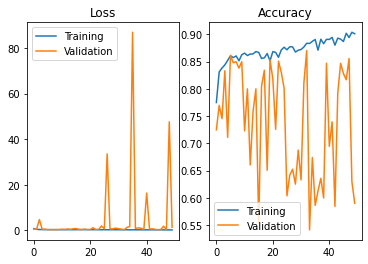

In [29]:
# LR = 1e-2
plot_loss_acc(overall_train_loss, overall_val_loss, overall_train_acc, overall_val_acc)
model.load_state_dict(torch.load('resnet-model-1e-2.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 10
Total Time Spent: 1m 7s
Test Loss: 0.300 | Test Acc: 86.36%


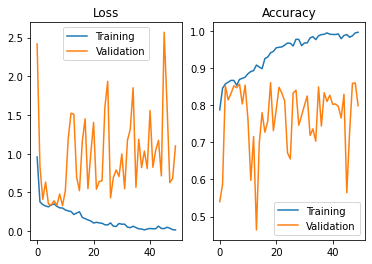

In [47]:
# LR = 1e-3
plot_loss_acc(overall_train_loss, overall_val_loss, overall_train_acc, overall_val_acc)
model.load_state_dict(torch.load('resnet-model-1e-3.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 4
Total Time Spent: 0m 27s
Test Loss: 0.363 | Test Acc: 83.83%


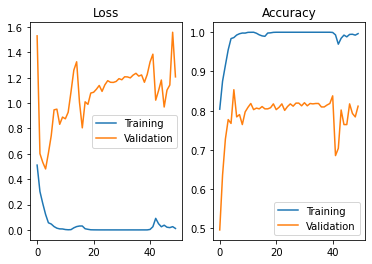

In [65]:
# LR = 1e-4
plot_loss_acc(overall_train_loss, overall_val_loss, overall_train_acc, overall_val_acc)
model.load_state_dict(torch.load('resnet-model-1e-4.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')